## Пример: House Sales in King County, USA <a name="house_case"></a>

Будем пробовать различные методы, чтобы научиться определять цену на недвижимость.  
Данные взяты с [одноименного соревнования](https://www.kaggle.com/harlfoxem/housesalesprediction) на Kaggle.  

Данные содержат информацию о продажах индивидуальных домов в период с мая 2014 года по май 2015 в округе Кинг, штат Вашингтон, США.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('seaborn')

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

pd.set_option('display.max_columns', 25)

In [4]:
house_data = pd.read_csv("kc_house_data.csv.zip")

In [5]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Давайте сымитируем ситуацию, когда заказчик скрыл часть данных.

In [45]:
holdout = house_data.sample(2000) # рандомная скрытая часть
house_data = house_data.loc[~house_data.index.isin(holdout.index)] #наш датасет без скрытой части

И будем дальше работать с house_data, как будто части holdout у нас никогда не было

### Комментарии по признакам

__price__ - целевая переменная (y).

__id__ - уникален для каждого объекта, необходимо удалить из выборки.

Посмотрим еще на три признака: 
* __sqft_living__ - общая площадь дома
* __sqft_above__ - общая площадь наземной части дома
* __sqft_basement__ - общая площадь подземного части дома  
  
Здравый смысл нам подсказывает, что эти признаки линейно связаны, а именно:  
$$sqft\_basement = sqft\_living - sqft\_above$$
  

In [62]:
print(house_data.sqft_basement == (house_data.sqft_living - house_data.sqft_above))

0        True
1        True
2        True
3        True
4        True
         ... 
21606    True
21607    True
21609    True
21610    True
21612    True
Length: 19613, dtype: bool


Поэтому признак sqft_basement можно удалить, оставив остальные два.

Признаки **lat** и **long** неоднозначные, но оставим их - вдруг помогут учесть географическое расположение домов. 

In [63]:
house_data[['lat', 'long']].describe()

,lat,long
count,19613.000000,19613.000000
mean,47.560131,-122.214072
std,0.138617,0.140755
min,47.155900,-122.519000
25%,47.470900,-122.328000
50%,47.571600,-122.230000
75%,47.678200,-122.125000
max,47.777600,-121.315000


### Предобработка данных

Удалим явным образом не подходящие признаки.

In [7]:
data = house_data.drop(['id', 'zipcode', 'date', 'sqft_living'], axis=1, inplace=False)

## Обучающая и тестовая выборки <a name="train_test"></a>

Для тестирования для начала применим простой метод - разделите датасет на две части: на одной будем обучать, на другой оценивать качество модели.  


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
y = data['price']
X = data.iloc[:,1:] # оставили все колонки без price

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1),
                                            data['price'],
                                            test_size=0.3, 
                                            random_state=5)

## K Nearest Neighbors <a name="knn"></a>

Будем обучаться на данных X_train. Нормализуйте X_train и добавьте KNeighborsRegressor с параметром n_neigbors = 5. Посчитайте чему равна MSE.

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

knrModel = make_pipeline (
 MinMaxScaler(),KNeighborsRegressor(n_neighbors=5))

knrModel.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [12]:
mse = mean_squared_error(y_pred=knrModel.predict(X_test), y_true=y_test)

In [13]:
mse

26792194240.85878

Теперь в цикле подберите переберите параметр n_neigbors и по графику ошибок mse определите оптимальное значение

In [14]:
knrModel = make_pipeline(MinMaxScaler())
X_train = knrModel.fit_transform(X_train)
X_test = knrModel.transform(X_test)

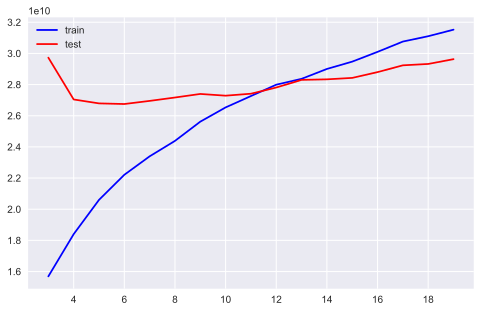

In [15]:
neighbors = range(3, 20)
errors_train = []
errors_test = []

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    errors_train.append(mean_squared_error(knn.predict(X_train), y_train))
    errors_test.append(mean_squared_error(knn.predict(X_test), y_test))
    
plt.plot(neighbors, errors_train, color='blue', label='train')
plt.plot(neighbors, errors_test, color='red', label='test')
plt.legend()


Постройте такой же график, только для median_absolute_error. Совпадают ли оптимальные значения n_neigbors для 2 типов ошибок?

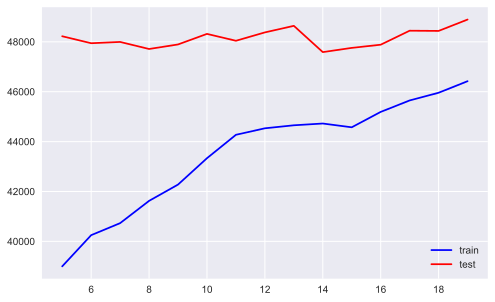

In [16]:
from sklearn.metrics import median_absolute_error
neighbors = range(5, 20)
errors_train = []
errors_test = []

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    errors_train.append(median_absolute_error(knn.predict(X_train), y_train))
    errors_test.append(median_absolute_error(knn.predict(X_test), y_test))
    
plt.plot(neighbors, errors_train, color='blue', label='train')
plt.plot(neighbors, errors_test, color='red', label='test')
plt.legend()


## Подбор k на кросс-валидации

Теперь с помощью GridSearchCV (cv=5) переберите параметр n_neighbors еще раз и выведите best_score_ и best_params_

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,3,1.00,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,3,2.25,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,2,1.00,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,4,3.00,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,3,2.00,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1131,3.0,0,0,3,8,1530,0,2009,0,47.6993,-122.346,1530,1509
21609,4,2.50,5813,2.0,0,0,3,8,2310,0,2014,0,47.5107,-122.362,1830,7200
21610,2,0.75,1350,2.0,0,0,3,7,1020,0,2009,0,47.5944,-122.299,1020,2007
21611,3,2.50,2388,2.0,0,0,3,8,1600,0,2004,0,47.5345,-122.069,1410,1287


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

param_grid = [
    {'kneighborsregressor__n_neighbors': range(10,14)},
]

knn = make_pipeline(
    MinMaxScaler(),
    KNeighborsRegressor() 
)

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error',n_jobs = -1, verbose=True, return_train_score=True)
grid_search.fit(X, y)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
-87286.73716706857
{'kneighborsregressor__n_neighbors': 10}


Теперь посомотрим как менялась ошибка на обучающей и тестовой части по время обучения, нарисуйте на графике 2 кривые  grid_search.cv_results_['mean_train_score'] и grid_search.cv_results_['mean_test_score']

In [19]:
grid_search.cv_results_

{'mean_fit_time': array([0.01502142, 0.04377294, 0.16438012, 0.02587047]),
 'std_fit_time': array([0.00077269, 0.03558138, 0.13293841, 0.00329694]),
 'mean_score_time': array([13.15346866, 12.79464908,  8.10062718, 22.18501959]),
 'std_score_time': array([0.16952178, 0.44550668, 7.21477515, 0.31836014]),
 'param_kneighborsregressor__n_neighbors': masked_array(data=[10, 11, 12, 13],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'kneighborsregressor__n_neighbors': 10},
  {'kneighborsregressor__n_neighbors': 11},
  {'kneighborsregressor__n_neighbors': 12},
  {'kneighborsregressor__n_neighbors': 13}],
 'split0_test_score': array([-89093.77048177, -89122.83173823, -89291.92592829, -89673.29441754]),
 'split1_test_score': array([-87602.65880704, -88103.608208  , -88187.97652732, -88153.44440087]),
 'split2_test_score': array([-82219.42449656, -82770.5040901 , -82873.98158297, -82883.40796878]),
 'split3_test_score': array([-

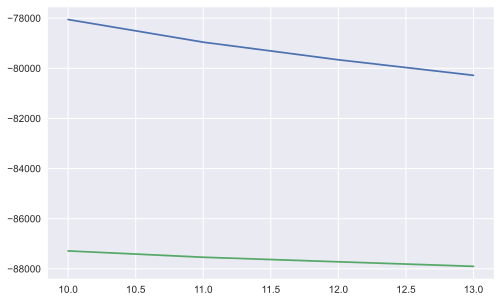

In [35]:
plt.plot([10,11,12,13],grid_search.cv_results_['mean_train_score'])
plt.plot([10,11,12,13],grid_search.cv_results_['mean_test_score'])

Теперь попробуем перебрать все возможные параметры KNeighborsRegressor. Добавьте в param_grid переменные kneighborsregressor__weights,
kneighborsregressor__metric(почитайте в документации какие значения она может принимать). Выведите best_score_ и best_params_


In [67]:
param_grid = [
    {'kneighborsregressor__n_neighbors': range(10,14),
    'kneighborsregressor__weights': ['uniform','distance'],
    'kneighborsregressor__metric': ['euclidean','manhattan','minkowski']}
]

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_absolute_error',n_jobs = -1, verbose=True, return_train_score=True)
grid_search.fit(X, y)

print(grid_search.best_score_)
print(grid_search.best_params_)

И наконец последний этап, контрольная проверка. Вспомним что у нас была скрытая выборка holdout. Теперь c ней нужно проделать те же преобразования, что и c обучающей выборкой - удалить лишние колонки, а потом применить grid_search.best_estimator_.predict) - получим предсказанные цены на скрытой части данных. 

In [46]:
holdout_pred = grid_search.best_estimator_.predict(holdout[X.columns])

Остается только сравнить предсказания с истинными значениями holdout['price'] и вывести mse. 

In [47]:
mean_squared_error(holdout_pred, holdout['price'])

23118205057.705704

In [50]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(holdout_pred, holdout['price'])

79077.9048

Если модель обучилась хорошо, то ошибка на holdout выборке будет примерно равна ошибка на нашей собственной тестовой части, т.е. grid_search.best_score_

## Дополнительное задание для любознательных

Повторите последний этап обучения gridsearch, в param_grid подставьте только по одному оптимальному значению из grid_search.best_params_, а вместо cv = 5 подставьте cv = LeaveOneOut(). Засеките время работы алгоритма.
Улучшился ли результат?

In [68]:
#Ваш код здесь